In [12]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from utils.likelihood import *
from utils.formate_matrix_toMLData import *
from models.model_for_lognormal import *
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams["font.size"] = 22
np.set_printoptions(suppress=True)


In [14]:
data_dir = "../datas/for_lognormal"
test_states = []
test_del_t = []
test_targets = []
dataset = []
data_formater = formate_dataMatrix()

def process_file(file_path):
    #ファイルの読み込み
    with open(file_path,encoding="utf-8-sig") as f:
        all_matrix = np.loadtxt(f, delimiter= ",")
    tm = matrix_trimer(all_matrix)
    trm = tm.trim_transitionRateMatrix()
    data = tm.trim_data()
    dataset.append(data)
    output_vec = np.array(data_formater.GetOutputVector_byDiagonal(trm))
    
    state = np.stack([data[:,0], data[:,1]], axis=0)
    test_states.append(state)
    
    test_del_t.append(data[:, 2])
    
    test_targets.append(output_vec)
    print(file_path)

data_formater.process_all_files_in_directory(data_dir,process_file)


# データセットとデータローダーの作成
test_dataset = varSets_Datasets(test_states, test_del_t, test_targets)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_iter = iter(test_dataloader)

../datas/for_lognormal\0_30000_4.csv
../datas/for_lognormal\100_30000_4.csv
../datas/for_lognormal\101_30000_4.csv
../datas/for_lognormal\102_30000_4.csv
../datas/for_lognormal\103_30000_4.csv
../datas/for_lognormal\104_30000_4.csv
../datas/for_lognormal\105_30000_4.csv
../datas/for_lognormal\106_30000_4.csv
../datas/for_lognormal\107_30000_4.csv
../datas/for_lognormal\108_30000_4.csv
../datas/for_lognormal\109_30000_4.csv
../datas/for_lognormal\10_30000_4.csv
../datas/for_lognormal\110_30000_4.csv
../datas/for_lognormal\111_30000_4.csv
../datas/for_lognormal\112_30000_4.csv
../datas/for_lognormal\113_30000_4.csv
../datas/for_lognormal\114_30000_4.csv
../datas/for_lognormal\115_30000_4.csv
../datas/for_lognormal\116_30000_4.csv
../datas/for_lognormal\117_30000_4.csv
../datas/for_lognormal\118_30000_4.csv
../datas/for_lognormal\119_30000_4.csv
../datas/for_lognormal\11_30000_4.csv
../datas/for_lognormal\120_30000_4.csv
../datas/for_lognormal\121_30000_4.csv
../datas/for_lognormal\122_30

In [15]:
# load model
model = DeepSets_varSets_forDiagnel()
model.load_state_dict(torch.load("../model_weights/lognormal_distribution_delT/model_weights.pth"))
model.eval()

DeepSets_varSets_forDiagnel(
  (embedding): Embedding(4, 2)
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=16, out_features=64, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
)

In [16]:
loss_list = []
outs_lifespan = []
true_lifespan = []
class all_lifespan_loss(nn.Module):
    def forward(self, outputs, targets):
        epsilon = 1e-12
        y_pred_inverse = 1.0 / (outputs + epsilon)
        y_true_inverse = 1.0 / (targets + epsilon)
        
        # 逆数の差の絶対値
        loss_tensor = torch.abs(y_pred_inverse - y_true_inverse)[0]
        return loss_tensor, y_true_inverse[0], y_pred_inverse
criterion = all_lifespan_loss()

for a, b, c,d in data_iter:
    with torch.no_grad():
        out = model(a, b, d)[0]
        loss, true_expect ,pred_expect= criterion(out,c)
        
        for i in range(3):
            true_lifespan.append(true_expect[i].item())
            outs_lifespan.append(pred_expect[i].item())

df = pd.DataFrame()
df["true"] = true_lifespan
df["pred"] = outs_lifespan
df["loss"] = (df["true"] - df["pred"]).abs()


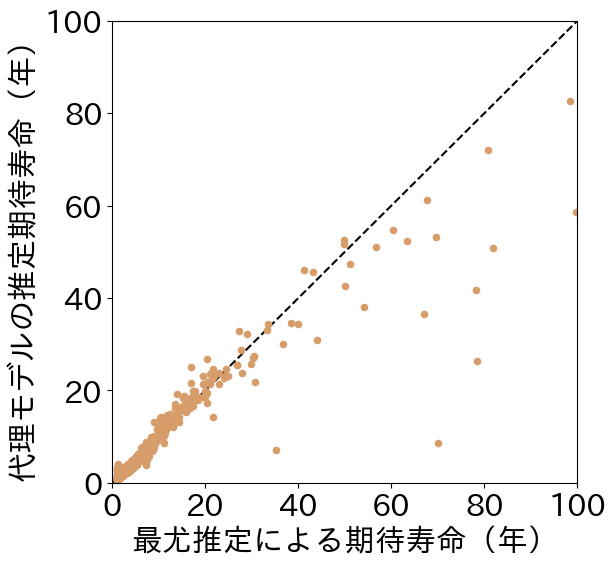

In [17]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 100, 1000)

plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("最尤推定による期待寿命（年）")
plt.ylabel("代理モデルの推定期待寿命（年）")
plt.plot(x,x,color="#000000", linestyle = '--',zorder= 0)
plt.scatter(df["true"],df["pred"],color = "#d69c6a",edgecolors="#d79e6b",s = 20,  zorder= 1)


4343


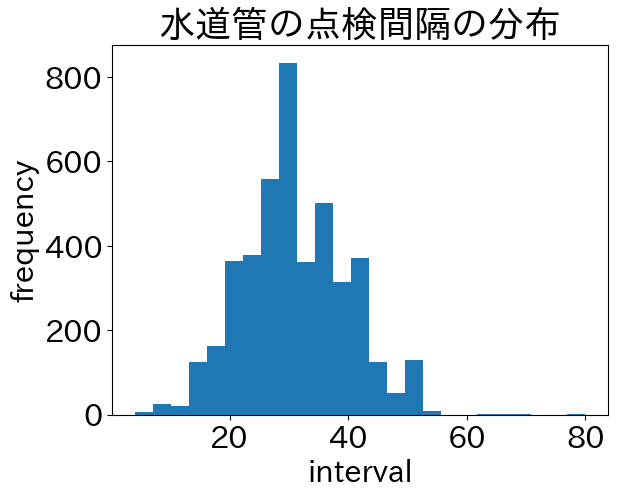

In [18]:
# # 水道管 12.3が良さそう
r = 12.3
real_data_dir = "../real_data/suidou.csv"
df = pd.read_csv(real_data_dir,delimiter=",")
df = df[["建設時健全度（1と仮定）","調査時健全度","経過年数"]]
df.columns = ["pre", "post", "time"]
plt.hist(df["time"],bins=25)
plt.xlabel("interval")
plt.ylabel("frequency")
plt.title("水道管の点検間隔の分布")
print(len(df))

In [19]:
# likelihood process
state = np.array([df["pre"],df["post"]])
del_t = np.array(df["time"]/r)

data = np.column_stack((state.T,del_t.T))
ll = Likelihood_diagonal_exp(data)
Q = ll.optimize(np.array([-0.5,-1,-1.5]))
formater = formate_dataMatrix()
vec = formater.GetOutputVector_byDiagonal(Q)

In [20]:
dataset = varSets_Datasets([state],[del_t], [vec])
dataloader = DataLoader(dataset, batch_size=1,shuffle=False,collate_fn=collate_fn)
pred = []
expect = []
for a, b, c,d in dataloader:
    with torch.no_grad():
        out = model(a, b, d)
        pred = r/out
        expect = r/c    
    print(f"output is {out}")
    print(f"target is {c}")
    print(f"pred is {pred}")
    print(f"expect is {expect}")

output is tensor([[0.5420, 0.6777, 0.1961]])
target is tensor([[0.5515, 0.6513, 0.3179]])
pred is tensor([[22.6930, 18.1505, 62.7118]])
expect is tensor([[22.3031, 18.8850, 38.6927]])


代理モデルによる劣化推移予測


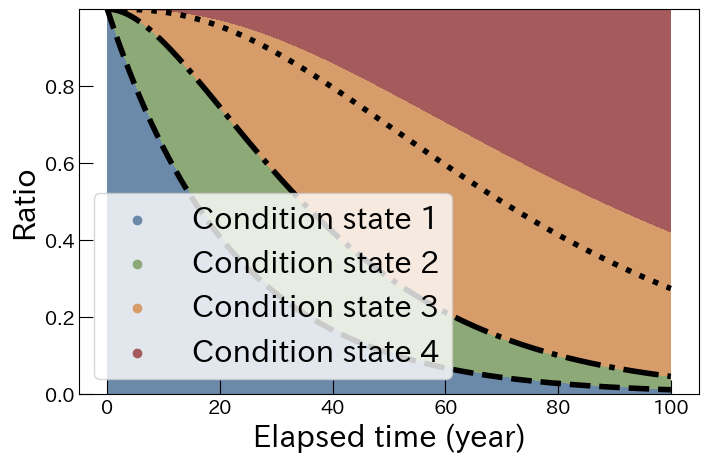

In [21]:
colors= ['#6b89a9', '#8ea978', '#d69c6a', '#a55a5b'] #彩度下げ冷暖色
plt.rcParams["figure.figsize"] = (8, 5)

sequence = np.arange(0, 100, 0.01)
def visualize(Q,title):
    vecs = []
    for t in sequence:
        P = expm(Q * t)
        vecs.append(P[0])
    
    for i, vec in enumerate(vecs):
        bottom = 0
        # vec = vec[::-1]
    
        for j, value in enumerate(vec):
            plt.bar(sequence[i], value, bottom=bottom, color=colors[j],width=0.01)
            bottom += value
    for i in range(len(colors)):
        plt.scatter([],[], color = colors[i],label = f"Condition state {i+1}")
    vecs = np.array(vecs)
    
    plot_trueline(c[0])
    plt.tick_params(axis='x', labelsize=14, direction='in', length=10)
    plt.tick_params(axis='y', labelsize=14, direction='in', length=10)
    plt.xlabel("Elapsed time (year)", fontsize = 22)
    plt.ylabel("Ratio", fontsize = 22)
    # plt.title(title, fontsize = 18)
    plt.legend(loc = "lower left")
    plt.show()
    
def generate_Q_from_diagonal(vec):
        Q = np.zeros((4,4))
        for i in range(len(vec)):
            Q[i,i+1]= vec[i]
            Q[i,i] = -Q[i,i+1]
        return Q
def plot_trueline(vec):
    true_vecs = []
    true_Q = generate_Q_from_diagonal(vec/r)
    for t in sequence:
        P = expm(true_Q * t)
        true_vecs.append(P[0])
    true_vecs = np.array(true_vecs)
    
    plt.plot(sequence,true_vecs[:,0],linestyle = "--",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1],linestyle = "-.",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1]+true_vecs[:,2],linestyle = ":",color = "black",lw = 4)
    

print("代理モデルによる劣化推移予測")
visualize(generate_Q_from_diagonal(out[0]/r),"代理モデルによる劣化推移予測")